In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

sample_df = pd.read_csv("cleaned_under_gdpr_propensity_sentiment.csv")

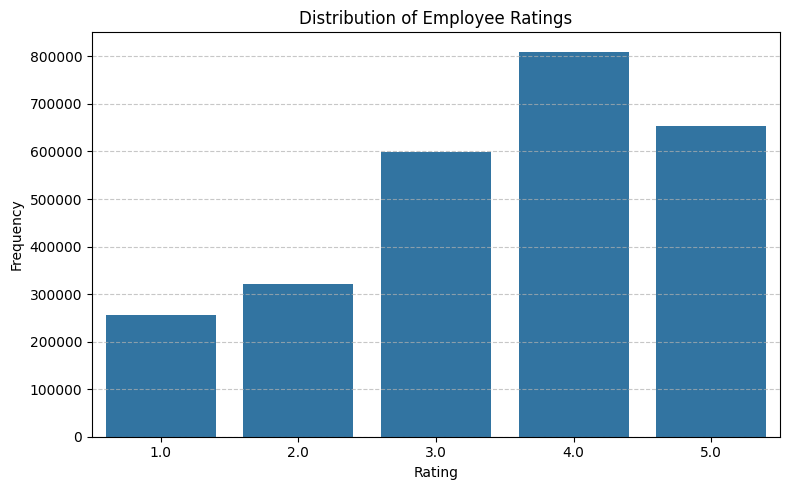

In [5]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=sample_df, order=sorted(sample_df['rating'].dropna().unique()))
plt.title('Distribution of Employee Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


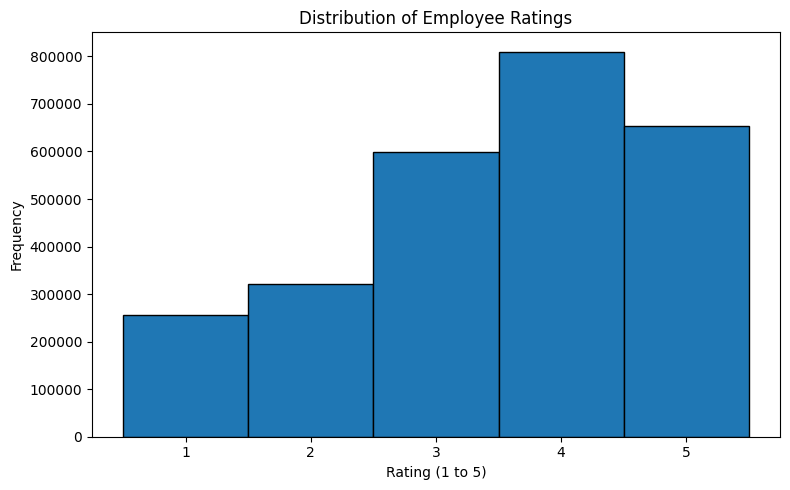

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(sample_df['rating'].dropna(), bins=[1, 2, 3, 4, 5, 6], edgecolor='black', align='left')
plt.title('Distribution of Employee Ratings')
plt.xlabel('Rating (1 to 5)')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()


In [9]:
# Step 1: Create relative year from GDPR (2018)
sample_df['date'] = pd.to_datetime(sample_df['date'])
sample_df['gdpr_year'] = sample_df['date'].dt.year - 2018

# Step 2: Create leads/lags (excluding -1 as the reference year)
rel_years = [-2, 0, 1, 2]
for yr in rel_years:
    base = f"year_sans{abs(yr)}" if yr < 0 else f"year_{yr}"
    sample_df[base] = (sample_df['gdpr_year'] == yr).astype(int)
    sample_df[f"{base}_treated"] = sample_df[base] * sample_df['under_gdpr']

# Step 3: Build the regression formula
event_terms = [f"year_sans{abs(yr)}_treated" if yr < 0 else f"year_{yr}_treated" for yr in rel_years]
covariates = [
    'company_size_Mid_Size',
    'company_size_Small',
    'seniority_level_Mid_Level',
    'seniority_level_Senior',
    'CEO_Approval_Sentiment',
    'Business_Outlook_Sentiment',
    'Recommmend_sentiment',
    'C(year)',
    'under_gdpr'
]
formula = 'rating ~ ' + ' + '.join(event_terms + covariates) 


# Step 4: Fit the model
event_model = smf.ols(formula=formula, data=sample_df.dropna(subset=['rating'])).fit()
print(event_model.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 1.627e+05
Date:                Fri, 06 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:31:22   Log-Likelihood:            -3.4346e+06
No. Observations:             2639670   AIC:                         6.869e+06
Df Residuals:                 2639653   BIC:                         6.869e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

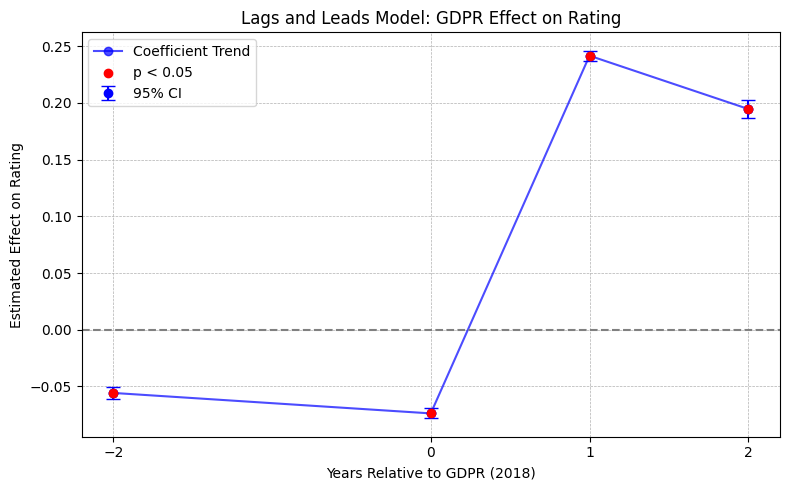

In [4]:
# Extract model results
coefs = event_model.params
conf_int = event_model.conf_int()
pvals = event_model.pvalues

# Prepare plot data
plot_data = pd.DataFrame({
    'event_time': rel_years,
    'coef': [coefs[f"year_sans{abs(yr)}_treated"] if yr < 0 else coefs[f"year_{yr}_treated"] for yr in rel_years],
    'ci_lower': [conf_int.loc[f"year_sans{abs(yr)}_treated", 0] if yr < 0 else conf_int.loc[f"year_{yr}_treated", 0] for yr in rel_years],
    'ci_upper': [conf_int.loc[f"year_sans{abs(yr)}_treated", 1] if yr < 0 else conf_int.loc[f"year_{yr}_treated", 1] for yr in rel_years],
    'pval': [pvals[f"year_sans{abs(yr)}_treated"] if yr < 0 else pvals[f"year_{yr}_treated"] for yr in rel_years]
})

plot_data['significant'] = plot_data['pval'] < 0.05

# Plot
plt.figure(figsize=(8, 5))

# Coeff trend line
plt.plot(plot_data['event_time'], plot_data['coef'], linestyle='-', marker='o', color='blue', alpha=0.7, label='Coefficient Trend')

# Error bars (95% CI)
plt.errorbar(
    plot_data['event_time'], plot_data['coef'],
    yerr=[plot_data['coef'] - plot_data['ci_lower'], plot_data['ci_upper'] - plot_data['coef']],
    fmt='o', capsize=5, color='blue', label='95% CI'
)

# Highlight significant points
plt.scatter(
    plot_data['event_time'][plot_data['significant']],
    plot_data['coef'][plot_data['significant']],
    color='red', zorder=5, label='p < 0.05'
)

# Reference line at 0
plt.axhline(0, color='gray', linestyle='--')

# Formatting
plt.title('Lags and Leads Model: GDPR Effect on Rating')
plt.xlabel('Years Relative to GDPR (2018)')
plt.ylabel('Estimated Effect on Rating')
plt.xticks(plot_data['event_time'])
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
sample_df.columns

Index(['company_name', 'date', 'rating', 'status', 'job',
       'CEO_Approval_Sentiment', 'Business_Outlook_Sentiment',
       'Recommmend_sentiment', 'eu_status', 'founded_year', 'under_gdpr',
       'industry', 'month', 'treated', 'company_size_Mid_Size',
       'company_size_Small', 'seniority_level_Mid_Level',
       'seniority_level_Senior', 'propensity_score', 'vader_sentiment', 'year',
       'gdpr_year', 'post_gdpr', 'did', 'clean_full_review', 'year_sans2',
       'year_sans2_treated', 'year_0', 'year_0_treated', 'year_1',
       'year_1_treated', 'year_2', 'year_2_treated', 'post_treated'],
      dtype='object')

In [10]:
import pandas as pd
import statsmodels.formula.api as smf

# Step 1: Define the 'post' treatment indicator
sample_df['date'] = pd.to_datetime(sample_df['date'])
sample_df['post_gdpr'] = (sample_df['date'].dt.year >= 2018).astype(int)

# Step 2: Create the interaction term
sample_df['post_treated'] = sample_df['post_gdpr'] * sample_df['under_gdpr']

# Step 3: Define covariates
covariates = [
    'company_size_Mid_Size',
    'company_size_Small',
    'seniority_level_Mid_Level',
    'seniority_level_Senior',
    'CEO_Approval_Sentiment',
    'Business_Outlook_Sentiment',
    'Recommmend_sentiment',
    'C(year)'  # Optional fixed effects for year
]

# Step 4: Build the formula
did_formula = 'rating ~ post_gdpr + under_gdpr + post_treated + ' + ' + '.join(covariates)

# Step 5: Fit the model
did_model = smf.ols(formula=did_formula, data=sample_df.dropna(subset=['rating'])).fit()
print(did_model.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 1.844e+05
Date:                Fri, 06 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:22:48   Log-Likelihood:            -3.4402e+06
No. Observations:             2639670   AIC:                         6.880e+06
Df Residuals:                 2639655   BIC:                         6.881e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [17]:
unique_companies = sample_df['company_name'].nunique()
print(f"Number of unique companies: {unique_companies}")


Number of unique companies: 1589


In [15]:
import pandas as pd
import statsmodels.formula.api as smf

# Step 1: Prepare data
sample_df['date'] = pd.to_datetime(sample_df['date'])
sample_df['post_gdpr'] = (sample_df['date'].dt.year >= 2018).astype(int)
sample_df['post_treated'] = sample_df['post_gdpr'] * sample_df['under_gdpr']

# Step 2: Define covariates and fixed effects
covariates = [
    'company_size_Mid_Size',
    'company_size_Small',
    'seniority_level_Mid_Level',
    'seniority_level_Senior',
    'CEO_Approval_Sentiment',
    'Business_Outlook_Sentiment',
    'Recommmend_sentiment',
    'C(year)',        # Time fixed effects
    'C(company_name)'      # Firm fixed effects (adapt to your actual firm column)
]

# Step 3: Build formula for DiD with fixed effects
did_formula = 'vader_sentiment ~ post_gdpr + under_gdpr + post_treated + ' + ' + '.join(covariates)

# Step 4: Fit the model
did_model = smf.ols(formula=did_formula, data=sample_df.dropna(subset=['vader_sentiment'])).fit()

# Step 5: Print summary
print(did_model.summary())


MemoryError: Unable to allocate 31.5 GiB for an array with shape (2639670, 1603) and data type float64

In [12]:
import pandas as pd
import statsmodels.formula.api as smf

# Step 1: Prepare data
sample_df['date'] = pd.to_datetime(sample_df['date'])
sample_df['post_gdpr'] = (sample_df['date'].dt.year >= 2018).astype(int)
sample_df['post_treated'] = sample_df['post_gdpr'] * sample_df['under_gdpr']

# Step 2: Define covariates and fixed effects
covariates = [
    'company_size_Mid_Size',
    'company_size_Small',
    'seniority_level_Mid_Level',
    'seniority_level_Senior',
    'CEO_Approval_Sentiment',
    'Business_Outlook_Sentiment',
    'Recommmend_sentiment',
    'C(year)',        # Time fixed effects
    'C(company_name)'      # Firm fixed effects (adapt to your actual firm column)
]

# Step 3: Build formula for DiD with fixed effects
did_formula = 'rating ~ post_gdpr + under_gdpr + post_treated + ' + ' + '.join(covariates)

# Step 4: Fit the model
did_model = smf.ols(formula=did_formula, data=sample_df.dropna(subset=['rating'])).fit()

# Step 5: Print summary
print(did_model.summary())


MemoryError: Unable to allocate 31.5 GiB for an array with shape (2639670, 1603) and data type float64